# IPCV Assignment 1

Authors:

- Mauro Dore             - mauro.dore@studio.unibo.it            - 0001105149
- Gian Mario Marongiu    - gianmario.marongiu@studio.unibo.it    - 0001092260
- Riccardo Murgia        - riccardo.murgia2@studio.unibo.it      - 0001083930

## Imports and Auxiliary Functions

In [2]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm


In [3]:
def show_multiple_images(image_list, cols=3, titles=None, global_title=None, plot_height=3):
    if not image_list:
        raise ValueError("The image list must not be empty.")

    num_images = len(image_list)

    if titles and len(titles) != num_images:
        raise ValueError("Titles list length must match the number of images.")

    rows = -(-num_images // cols)  # Equivalent to math.ceil

    fig, axes = plt.subplots(rows, cols, figsize=(10, plot_height * rows))
    fig.subplots_adjust(top=0.9 if global_title else 1.0)

    if global_title:
        fig.suptitle(global_title, fontsize=16, fontweight='bold')

    axes = axes.flatten() if num_images > 1 else [axes]

    for i, ax in enumerate(axes):
        if i < num_images:
            image = image_list[i]

            # Ensure the image is in an acceptable format (uint8)
            if image.dtype == np.float64:
                # Scale to 0-255 and convert to uint8
                image = np.uint8(np.clip(image * 255, 0, 255))

            # Handle both grayscale and color images
            if len(image.shape) == 2:  # Grayscale image (height, width)
                ax.imshow(image, cmap='gray')  # Use grayscale colormap for black-and-white images
            elif len(image.shape) == 3:  # Color image (height, width, channels)
                # Convert BGR to RGB if the image is in BGR format
                ax.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
            else:
                raise ValueError(f"Image at index {i} has invalid shape: {image.shape}")

            ax.set_axis_off()
            if titles:
                ax.set_title(titles[i], fontsize=12, fontweight='bold')
        else:
            ax.set_visible(False)

    plt.tight_layout()
    plt.show()


def compute_metrics(real_occurrences, predicted_occurrences):
    # Initialize variables to track TP, FP, FN
    true_positives = 0
    false_positives = 0
    false_negatives = 0

    # Iterate over each class/key in real occurrences
    for key in real_occurrences:
        real_set = set(real_occurrences[key])
        predicted_set = set(predicted_occurrences.get(key, []))

        # Compute true positives (correct predictions)
        tp = len(real_set & predicted_set)

        # Compute false positives (wrong predictions)
        fp = len(predicted_set - real_set)

        # Compute false negatives (missed real occurrences)
        fn = len(real_set - predicted_set)

        # Update counts
        true_positives += tp
        false_positives += fp
        false_negatives += fn

    # Calculate precision, recall, and F1 score
    precision = true_positives / (true_positives + false_positives) if true_positives + false_positives > 0 else 0
    recall = true_positives / (true_positives + false_negatives) if true_positives + false_negatives > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if precision + recall > 0 else 0

    # Return the metrics
    return precision, recall, f1
    
def png_to_numpy(path, list):
    for image_name in os.listdir(path):
        image_path = os.path.join(path, image_name)
        image = cv2.imread(image_path)
        list.append(image)

def print_detection_summary(real_matchings, detected_matchings):
    print("Detection summary:")
    for scene in real_matchings.keys():
        scene_str = f"Scene {scene}".ljust(20)
        present_models_str = f"Models in the image: {real_matchings[scene]}".ljust(60)
        detected_models_str = f"Models detected: {detected_matchings[scene]}"
    
        print(f"{scene_str} {present_models_str} {detected_models_str}")


In [4]:
MODELS_SINGLE_INSTANCE_PATH = "models_single_instance"
SCENES_SINGLE_INSTANCE_PATH = "scenes_single_instance"
MODELS_MULTIPLE_INSTANCES_PATH = "models_multiple_instances"
SCENES_MULTIPLE_INSTANCES_PATH = "scenes_multiple_instances"

models_single_instance = []
scenes_single_instance = []
models_multiple_instances = []
scenes_multiple_instances = []

png_to_numpy(MODELS_SINGLE_INSTANCE_PATH, models_single_instance)
png_to_numpy(SCENES_SINGLE_INSTANCE_PATH, scenes_single_instance)
png_to_numpy(MODELS_MULTIPLE_INSTANCES_PATH, models_multiple_instances)
png_to_numpy(SCENES_MULTIPLE_INSTANCES_PATH, scenes_multiple_instances)
    
print(f"{len(models_single_instance)} models and {len(scenes_single_instance)} scenes for single instance detection task")
print(f"{len(models_multiple_instances)} models and {len(scenes_multiple_instances)} scenes for multiple instances detection task")


14 models and 5 scenes for single instance detection task
12 models and 7 scenes for multiple instances detection task


## Task Analysis

The objective is to perform instance detection using the provided model images. Several challenges must be addressed:

- The scenes contain significant noise, which must be mitigated prior to detection;
- The models are noticeably brighter than the scenes, indicating the need for a method that is robust to intensity variations;
- The models and scenes exhibit considerable variation in shape, necessitating the use of a scale-invariant detector.

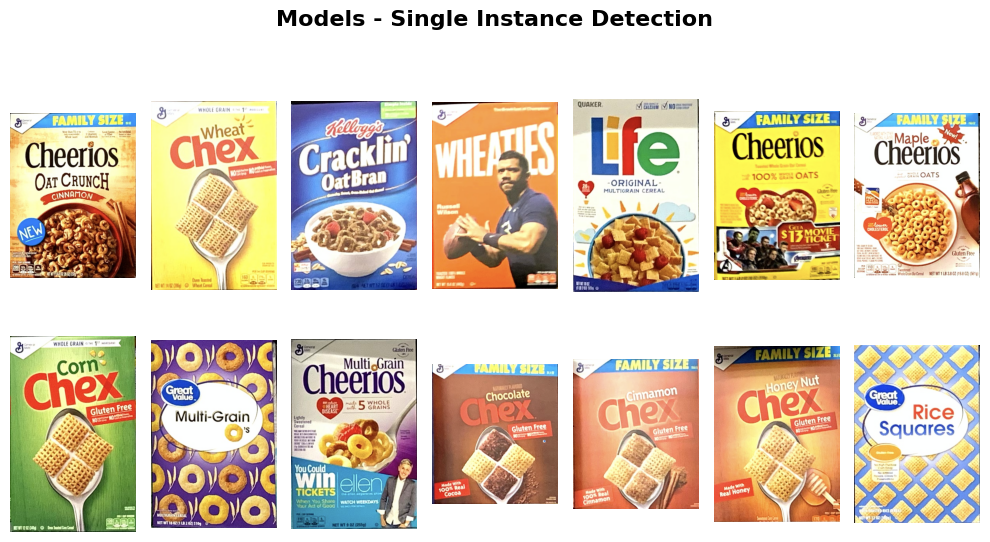

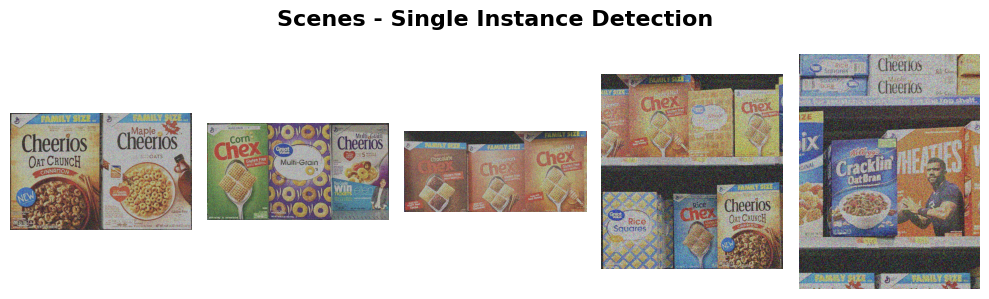

In [5]:
single_instance_real_matchings = {0: [0, 6], 1: [7, 8, 9], 2: [10, 11, 12], 3: [11, 12, 13, 1, 0], 4: [2, 3, 6]}
show_multiple_images(models_single_instance, cols=7, global_title="Models - Single Instance Detection")
show_multiple_images(scenes_single_instance, cols=5, global_title="Scenes - Single Instance Detection")


## Scenes Denoising

Single Detection Scenes Denoising: 100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


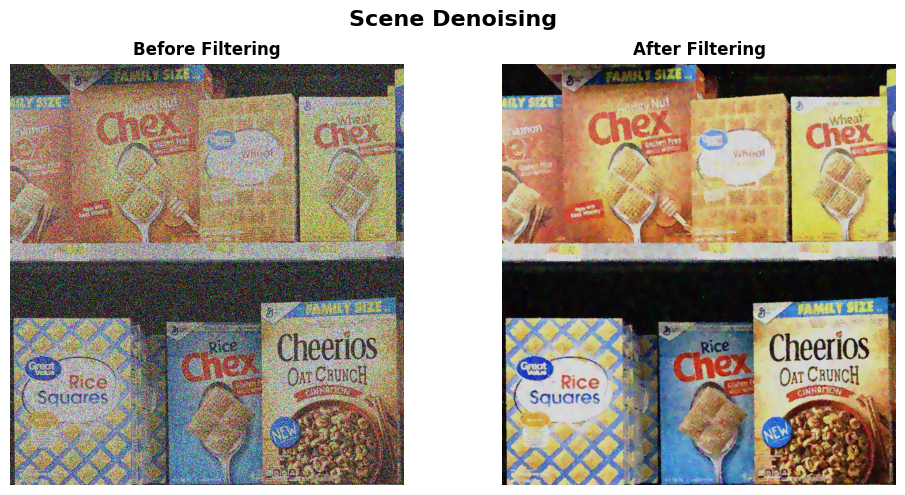

In [17]:
denoised_scenes_single_instance = []

#sigma = 2
#k_size = int(np.ceil((3*sigma))*2 + 1) #rule of thumb for a good kernel size given sigma

for scene in tqdm(scenes_single_instance, desc="Single Detection Scenes Denoising: "):
    #denoised_scene = cv2.GaussianBlur(scene, (k_size,k_size) , sigma)
    denoised_scene = cv2.medianBlur(scene, 3)
    denoised_scene = cv2.medianBlur(denoised_scene, 3)
    denoised_scene = cv2.bilateralFilter(denoised_scene, d=19, sigmaColor=50, sigmaSpace=250)
    #denoised_scene = cv2.bilateralFilter(denoised_scene, d=19, sigmaColor=35, sigmaSpace=250)
    denoised_scene = cv2.bilateralFilter(denoised_scene, d=19, sigmaColor=20, sigmaSpace=100)
    #denoised_scene = cv2.fastNlMeansDenoisingColored(denoised_scene, dst=None, h=3, hColor=3, templateWindowSize=7, searchWindowSize=21)
    denoised_scenes_single_instance.append(denoised_scene)
    
# example of a random denoised image
random_idx = np.random.randint(len(scenes_single_instance))
show_multiple_images([scenes_single_instance[random_idx], denoised_scenes_single_instance[random_idx]],
                     global_title=f"Scene Denoising",
                     titles=["Before Filtering", "After Filtering"],
                     cols=2,
                     plot_height=5)


## Single Instance Detection

In [7]:
def warp_model(model, homography, scene_shape):
    """
    Warps the entire model to the scene based on the homography matrix.
    Ensures that the warped model stays within the scene boundaries.
    """
    height, width = model.shape[:2]

    # Get the corner points of the model
    model_corners = np.float32([[0, 0], [0, height - 1], [width - 1, height - 1], [width - 1, 0]]).reshape(-1, 1, 2)

    # Warp the corner points to the scene using the homography matrix
    warped_corners = cv2.perspectiveTransform(model_corners, homography)

    # Get the bounding box of the warped model
    x_min = int(min(warped_corners[:, 0, 0]))
    x_max = int(max(warped_corners[:, 0, 0]))
    y_min = int(min(warped_corners[:, 0, 1]))
    y_max = int(max(warped_corners[:, 0, 1]))

    # Ensure the bounding box is within the scene boundaries
    h_scene, w_scene = scene_shape[:2]
    x_min = max(0, x_min)
    x_max = min(w_scene, x_max)
    y_min = max(0, y_min)
    y_max = min(h_scene, y_max)

    # Warp the entire model to the scene size using homography
    warped_model = cv2.warpPerspective(model, homography, (w_scene, h_scene))

    # Crop the corresponding region from the warped model and scene
    return warped_model[y_min:y_max, x_min:x_max], (x_min, y_min, x_max, y_max)

def zncc(patch1, patch2):
    # Subtract the mean from each patch (Zero mean)
    patch1_mean = patch1 - np.mean(patch1)
    patch2_mean = patch2 - np.mean(patch2)

    # Compute the numerator: sum of element-wise products of the zero-mean patches
    numerator = np.sum(patch1_mean * patch2_mean)

    # Compute the denominator: product of the standard deviations
    denominator = np.sqrt(np.sum(patch1_mean ** 2) * np.sum(patch2_mean ** 2))

    # Avoid division by zero
    if denominator == 0:
        return -1  # Return -1 if denominator is 0

    return numerator / denominator

def validate_matching(model, scene, homography, config):
    """
    Validate by comparing the entire warped model with the corresponding region in the scene.
    """
    # Warp the model and get the corresponding region in the scene
    model_warped, (x_min, y_min, x_max, y_max) = warp_model(model, homography, scene.shape)

    # Extract the corresponding region from the scene
    scene_region = scene[y_min:y_max, x_min:x_max]

    # Compare the entire warped model and the scene region using ZNCC
    zncc_score = zncc(model_warped, scene_region)
    return zncc_score > config["zncc_threshold"]


def object_retrieve(model, scene, config):
    sift = cv2.SIFT_create(contrastThreshold=config["sift_contrast_threshold"],
                           edgeThreshold=config["sift_edge_threshold"],
                           sigma=config["sift_sigma"],
                           nOctaveLayers=config["sift_n_octave_layers"])

    # Detect keypoints and compute descriptors
    keypoints_model, descriptors_model = sift.detectAndCompute(model, None)
    keypoints_scene, descriptors_scene = sift.detectAndCompute(scene, None)

    # FLANN parameters for matching
    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=config["flann_trees"])
    search_params = dict(checks=config["flann_checks"])
    flann = cv2.FlannBasedMatcher(index_params, search_params)

    # Match descriptors using k-NN (k=2)
    matches = flann.knnMatch(descriptors_model, descriptors_scene, k=2)

    # Lowe's ratio test to select good matches. m is first match, n is second match.
    good_matches = []
    for model_point, scene_point in matches:
        if model_point.distance < config["lowes_ratio_thresh"] * scene_point.distance:
            good_matches.append(model_point)

    # Ensure enough good matches were found
    if len(good_matches) < config["low_thresh_min_match"]:
        return False, scene, len(good_matches)

    # Extract coordinates from the good matches
    src_pts = np.float32([keypoints_model[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
    dst_pts = np.float32([keypoints_scene[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)

    # Find homography matrix
    homography, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)

    # Validate using zncc
    matching_exceeds_high_threshold = len(good_matches) > config["high_thresh_min_match"]
    matching_exceeds_low_threshold = len(good_matches) > config["low_thresh_min_match"]
    patch_check_is_valid = validate_matching(model, scene, homography, config)

    if matching_exceeds_high_threshold or (matching_exceeds_low_threshold and patch_check_is_valid):
        height, width = model.shape[:2]
        model_corners = np.float32([[0, 0], [0, height - 1], [width - 1, height - 1], [width - 1, 0]]).reshape(-1, 1, 2)
        dst = cv2.perspectiveTransform(model_corners, homography)
        scene_boxed = cv2.polylines(np.array(scene), [np.int32(dst)], True, (0, 255, 0), 5, cv2.LINE_AA)

        return True, scene_boxed, len(good_matches)
    else:
        return False, scene, len(good_matches)


In [10]:
config_single_instance = {
    # sift parameters
    "sift_contrast_threshold": 0.03,
    "sift_edge_threshold": 15,
    "sift_sigma": 1.5,
    "sift_n_octave_layers": 4,

    # flann parameters
    "flann_trees": 12,
    "flann_checks": 80,

    # feature matching parameters
    "low_thresh_min_match": 15,
    "high_thresh_min_match": 200,
    "lowes_ratio_thresh": 0.65,

    # Zero normalized cross-correlation parameters
    "zncc_threshold": 0.65,
}

single_model_scene_couples = []
single_instance_detected_matchings = {scene: [] for scene in range(len(scenes_single_instance))}

total_iterations = len(models_single_instance) * len(denoised_scenes_single_instance)
with tqdm(total=total_iterations, desc="Processing Models and Scenes") as pbar:
    for model_idx, model in enumerate(models_single_instance):
        for scene_idx, scene in enumerate(denoised_scenes_single_instance):
            found, scene_boxed, good_matches = object_retrieve(model=model, scene=scene, config=config_single_instance)
            single_model_scene_couples.append([model, scene_boxed, found, good_matches])

            if found:
                single_instance_detected_matchings[scene_idx].append(model_idx)

            pbar.update(1)

print_detection_summary(single_instance_real_matchings, single_instance_detected_matchings)

# todo: formattare output single instance detection come indicato nelle guidelines (MAURO)

Processing Models and Scenes: 100%|██████████| 70/70 [01:20<00:00,  1.15s/it]

Detection summary:
Scene 0              Models in the image: [0, 6]                                  Models detected: [0, 6]
Scene 1              Models in the image: [7, 8, 9]                               Models detected: [7, 8, 9]
Scene 2              Models in the image: [10, 11, 12]                            Models detected: [10, 11, 12]
Scene 3              Models in the image: [11, 12, 13, 1, 0]                      Models detected: [0, 1, 11, 12, 13]
Scene 4              Models in the image: [2, 3, 6]                               Models detected: [2, 3, 6]


In [12]:
PLOT_ALL_IMAGES = False

if PLOT_ALL_IMAGES:
    for model, scene, found, good_matches in single_model_scene_couples:
        show_multiple_images([model, scene], cols=2, global_title=f"{good_matches} good matches")


## Multiple Instances Detection

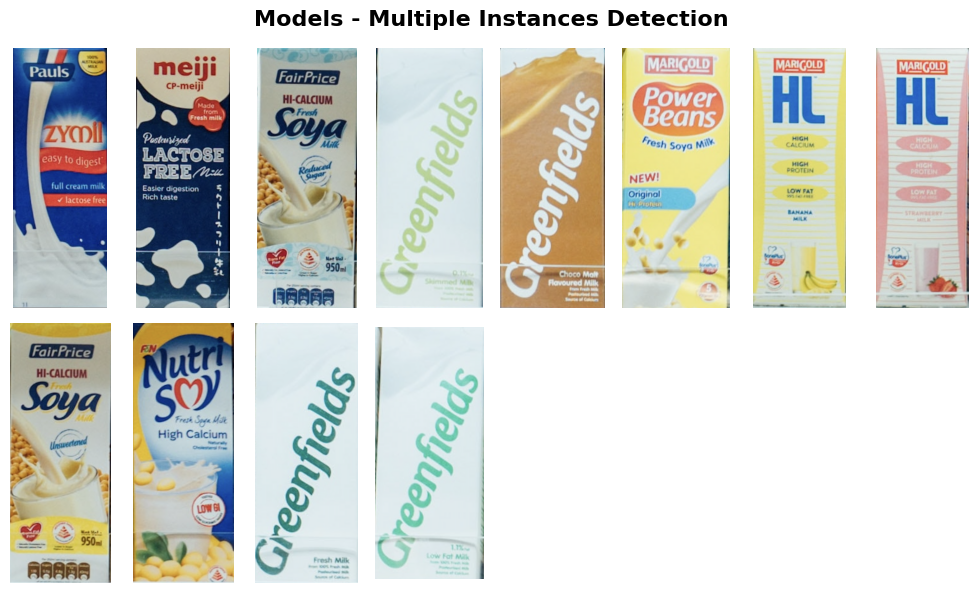

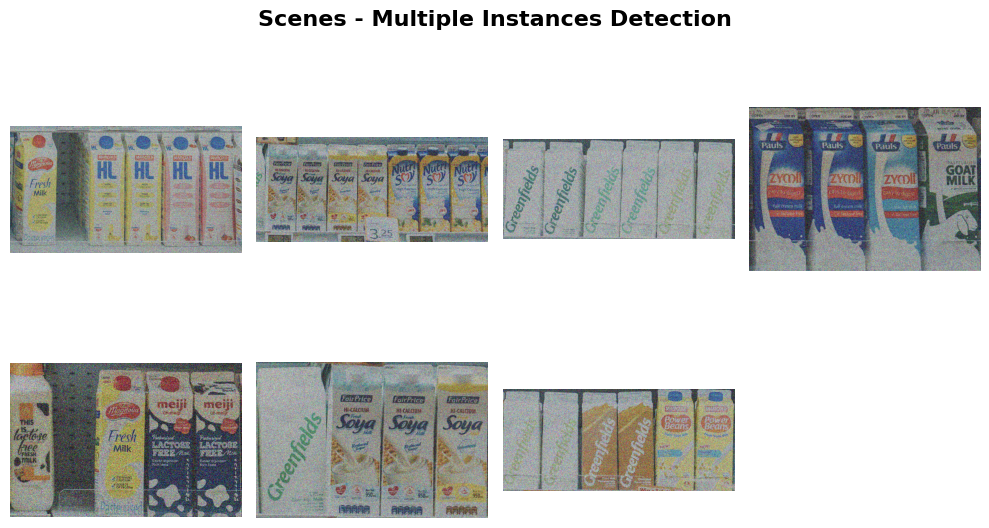

In [16]:
multi_instance_real_matchings = {0: [(6, 2), (7, 2)],
                                 1: [(2, 2), (8, 2), (9, 3)], 
                                 2: [(10, 2), (11, 2), (3, 2)], 
                                 3: [(0, 2)], 
                                 4: [(1, 2)], 
                                 5: [(2, 2), (8, 1)],
                                 6: [(3, 2), (4, 2), (5, 2)]}

show_multiple_images(models_multiple_instances, cols=8, global_title="Models - Multiple Instances Detection")
show_multiple_images(scenes_multiple_instances, cols=4, global_title="Scenes - Multiple Instances Detection")


In [44]:
def denoising_pipeline(image):
    denoised_image = cv2.medianBlur(image, 3)
    denoised_image = cv2.medianBlur(denoised_image, 3)
    denoised_image = cv2.bilateralFilter(denoised_image, d=19, sigmaColor=50, sigmaSpace=250)
    denoised_image = cv2.bilateralFilter(denoised_image, d=19, sigmaColor=20, sigmaSpace=120)
    return denoised_image

def load_np_images(path):
    image_list = []
    for image_name in os.listdir(path):
        image_path = os.path.join(path, image_name)
        image = cv2.imread(image_path)
        image_list.append(image)
    return image_list

def denoise_images(images):
    denoised_images = []
    for image in images:
        denoised_images.append(denoising_pipeline(image))
    return denoised_images

def compute_edges(images):
    edges_list = []

    for image in images:
        edges = cv2.Canny(image, 150, 220)
        edges_list.append(edges)

    return edges_list

def process_scenes(images):
    processed_images = []

    for image in images:
        image_normalized = cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX)
        image_uint8 = np.uint8(image_normalized)
        image_gray = cv2.cvtColor(image_uint8, cv2.COLOR_BGR2GRAY)

        processed_images.append(image_gray)

    return processed_images

def process_models_bw(images):
    processed_images = []

    for image in images:
        image_blurred = denoising_pipeline(image)
        image_normalized = cv2.normalize(image_blurred, None, 0, 255, cv2.NORM_MINMAX)
        image_uint8 = np.clip(image_normalized, 0, 255).astype(np.uint8)
        image = cv2.cvtColor(image_uint8, cv2.COLOR_BGR2GRAY)

        processed_images.append(image)

    return processed_images

def process_models_rgb(images):
    blurred_images = []
    for image in images:       
        image_blurred = denoising_pipeline(image)
        image_normalized = cv2.normalize(image_blurred, None, 0, 255, cv2.NORM_MINMAX)
        image_uint8 = np.clip(image_normalized, 0, 255).astype(np.uint8)
        blurred_images.append(image_uint8)
    return blurred_images

def compute_gradient_direction(edges, images):
    gradient_directions = []

    for image, mask in zip(images, edges):
        mask = (mask/255)
        grad_x = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=5)
        grad_y = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=5)
        gradient_direction = np.degrees(np.arctan2(grad_y, grad_x)+np.pi)
        gradient_direction_masked = mask*gradient_direction

        gradient_directions.append(gradient_direction_masked)

    return gradient_directions


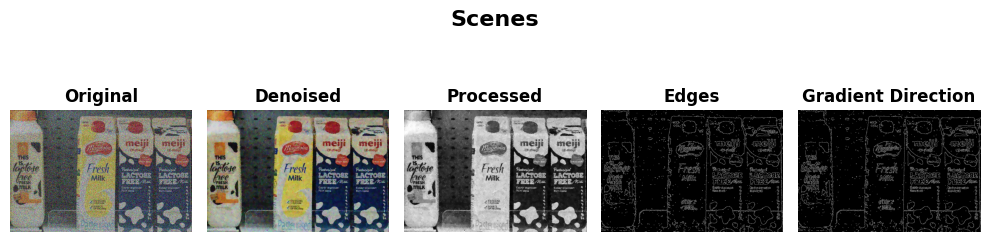

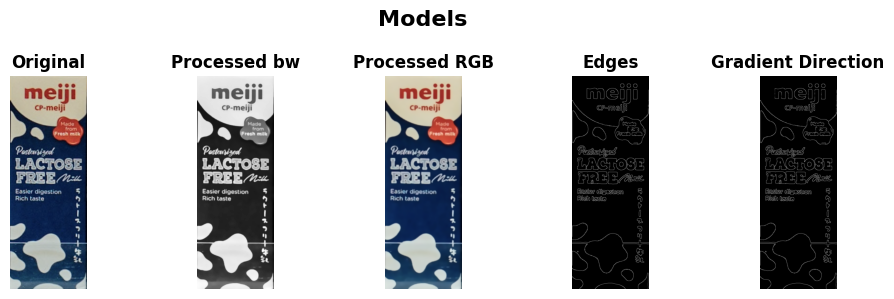

In [47]:
MODELS_MULTIPLE_INSTANCES_PATH = "models_multiple_instances"
SCENES_MULTIPLE_INSTANCES_PATH = "scenes_multiple_instances"

images = {
    "scenes": {
        "original_images" : None,
        "denoised_images" : None,
        "processed_images": None,
        "edges": None,
        "gradient_directions": None
    },
    "models": {
        "original_images" : None,
        "processed_images_bw": None,
        "processed_images_rgb": None,
        "edges": None,
        "gradient_directions": None
    }
}

images['scenes']['original_images'] = load_np_images(SCENES_MULTIPLE_INSTANCES_PATH)
images['scenes']['denoised_images'] = denoise_images(images['scenes']['original_images'])
images['scenes']['processed_images'] = process_scenes(images['scenes']['denoised_images'])
images['scenes']['edges'] = compute_edges(images['scenes']['processed_images'])
images['scenes']['gradient_directions'] = compute_gradient_direction(images['scenes']['edges'], images['scenes']['processed_images'])

images['models']['original_images'] = load_np_images(MODELS_MULTIPLE_INSTANCES_PATH)
images['models']['processed_images_bw'] = process_models_bw(images['models']['original_images'])
images['models']['processed_images_rgb'] = process_models_rgb(images['models']['original_images'])
images['models']['edges'] = compute_edges(images['models']['processed_images_bw'])
images['models']['gradient_directions'] = compute_gradient_direction(images['models']['edges'], images['models']['processed_images_bw'])

model_idx = 1
scene_idx = 4

show_multiple_images([images['scenes']['original_images'][scene_idx],
                      images['scenes']['denoised_images'][scene_idx],
                      images['scenes']['processed_images'][scene_idx],
                      images['scenes']['edges'][scene_idx],
                      images['scenes']['gradient_directions'][scene_idx]],
                      cols=5,
                      global_title="Scenes",
                      titles=["Original", "Denoised", "Processed", "Edges", "Gradient Direction"])

show_multiple_images([images['models']['original_images'][model_idx],
                      images['models']['processed_images_bw'][model_idx],
                      images['models']['processed_images_rgb'][model_idx],
                      images['models']['edges'][model_idx],
                      images['models']['gradient_directions'][model_idx]],
                      cols=5,
                      global_title="Models",
                      titles=["Original", "Processed bw", "Processed RGB", "Edges", "Gradient Direction"])


In [6]:
# Display shapes of each image category in 'scenes'
print("Scenes:")
print("  Original Images Shape:", np.shape(images['scenes']['original_images'][0]))
print("  Denoised Images Shape:", np.shape(images['scenes']['denoised_images'][0]))
print("  Processed Images Shape:", np.shape(images['scenes']['processed_images'][0]))
print("  Edges Shape:", np.shape(images['scenes']['edges'][0]))
print("  Gradient Directions Shape:", np.shape(images['scenes']['gradient_directions'][0]))

# Display shapes of each image category in 'models'
print("\nModels:")
print("  Original Images Shape:", np.shape(images['models']['original_images'][0]))
print("  Processed Images Shape:", np.shape(images['models']['processed_images_bw'][0]))
print("  Edges Shape:", np.shape(images['models']['edges'][0]))
print("  Gradient Directions Shape:", np.shape(images['models']['gradient_directions'][0]))


Scenes:
  Original Images Shape: (932, 1696, 3)
  Denoised Images Shape: (932, 1696, 3)
  Processed Images Shape: (932, 1696)
  Edges Shape: (932, 1696)
  Gradient Directions Shape: (932, 1696)

Models:
  Original Images Shape: (906, 326, 3)
  Processed Images Shape: (906, 326)
  Edges Shape: (906, 326)
  Gradient Directions Shape: (906, 326)


Processing scene edges:  96%|█████████▋| 324834/336808 [00:01<00:00, 214199.72it/s]

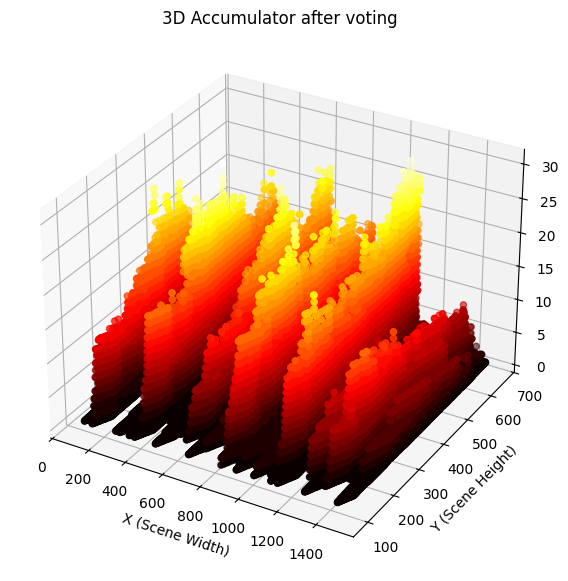

Processing scene edges: 100%|██████████| 336808/336808 [00:09<00:00, 35194.43it/s] 


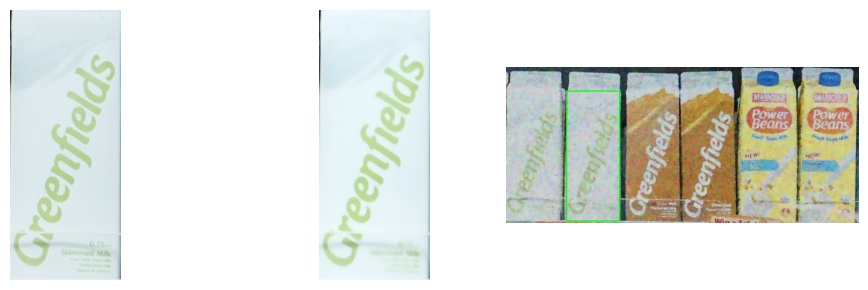

In [48]:
def plot_accumulator_array(accumulator):
    accumulator_max = np.max(accumulator, axis=2)
    y_indices, x_indices = np.indices(accumulator_max.shape)
    z_values = accumulator_max.flatten()
    x_values = x_indices.flatten()
    y_values = y_indices.flatten()

    # Filter out zero values to only plot significant peaks
    non_zero_indices = z_values > 0
    x_values = x_values[non_zero_indices]
    y_values = y_values[non_zero_indices]
    z_values = z_values[non_zero_indices]

    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(x_values, y_values, z_values, c=z_values, cmap='hot', marker='o')
    ax.set_title("3D Accumulator after voting")
    ax.set_xlabel("X (Scene Width)")
    ax.set_ylabel("Y (Scene Height)")
    ax.set_zlabel("Votes")
    plt.show()

def compute_max_min_scale(model, scene):
    model_height = model.shape[0]
    scene_height = scene.shape[0]

    max_scale = scene_height / model_height # scales down model height same as scene height
    min_scale = max_scale*0.7

    return max_scale, min_scale

def zncc(patch1, patch2):
    # Subtract the mean from each patch (Zero mean)
    patch1_mean = patch1 - np.mean(patch1)
    patch2_mean = patch2 - np.mean(patch2)

    # Compute the numerator: sum of element-wise products of the zero-mean patches
    numerator = np.sum(patch1_mean * patch2_mean)

    # Compute the denominator: product of the standard deviations
    denominator = np.sqrt(np.sum(patch1_mean ** 2) * np.sum(patch2_mean ** 2))

    # Avoid division by zero
    if denominator == 0:
        return -1  # Return -1 if denominator is 0

    return numerator / denominator

def build_r_table(edges, gradient_directions, reference_point, scales):
    """Builds the R-table for the given model at multiple scales using normal dictionaries."""
    r_table = {}

    # Iterate over all contours to compute vectors to the reference point for different scales
    for scale in scales:
        for edge_point in edges:
            # Calculate the vector from the edge point to the reference point
            scaled_vector = (reference_point - edge_point) * scale

            # Calculate the gradient direction (angle) of the edge at this point, discretize in 36 bins of size 10
            angle = gradient_directions[edge_point]
            angle_bin = int(angle // 10) * 10

            # Store the vector in the R-table using the gradient angle bin and scale as the key
            key = (angle_bin, scale)
            if key not in r_table:
                r_table[key] = []
            r_table[key].append(scaled_vector)

    return r_table


def non_maximum_suppression(boxes, scores, iou_threshold=0.5):
    if len(boxes) == 0:
        return []

    # Convert bounding boxes to numpy arrays for easier manipulation
    boxes = np.array(boxes)
    scores = np.array(scores)

    # Extract coordinates
    x1 = boxes[:, 0]
    y1 = boxes[:, 1]
    x2 = boxes[:, 2]
    y2 = boxes[:, 3]

    # Compute the area of each bounding box
    areas = (x2 - x1 + 1) * (y2 - y1 + 1)

    # Sort boxes by scores in descending order
    order = scores.argsort()[::-1]

    keep = []

    while len(order) > 0:
        i = order[0]  # Index of the box with the highest score
        keep.append(i)

        # Compute IoU of the kept box with all other boxes
        xx1 = np.maximum(x1[i], x1[order[1:]])
        yy1 = np.maximum(y1[i], y1[order[1:]])
        xx2 = np.minimum(x2[i], x2[order[1:]])
        yy2 = np.minimum(y2[i], y2[order[1:]])

        # Compute width and height of overlapping area
        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)

        # Compute the Intersection Over Union (IoU)
        inter = w * h
        union = areas[i] + areas[order[1:]] - inter
        iou = inter / union

        # Keep indices of boxes with IoU less than the threshold
        remaining_indices = np.where(iou <= iou_threshold)[0]
        order = order[remaining_indices + 1]

    return keep

def find_max_values(array, num_values):
    # Flatten the 3D array while keeping track of indices
    flattened_array = array.flatten()

    # Get the indices of the top `num_values` maximum values
    max_indices = np.argpartition(flattened_array, -num_values)[-num_values:]
    max_indices = max_indices[np.argsort(flattened_array[max_indices])[::-1]]

    # Convert flattened indices back to 3D indices
    max_indices = np.unravel_index(max_indices, array.shape)

    return max_indices


def multiple_object_retrieve_w_nms(models, scenes, model_idx, scene_idx, config, verbose=False):
    # Extract model and scene dimensions
    model_height, model_width, _ = models["original_images"][model_idx].shape
    scene_height, scene_width, _ = scenes["original_images"][scene_idx].shape

    # Retrieve scene edge information and gradient directions
    scene_edges = scenes["edges"][scene_idx]
    scene_edges_list = [tuple(point) for point in np.transpose(np.nonzero(scene_edges))]
    scene_gradient_direction = scenes["gradient_directions"][scene_idx]

    # Retrieve model edge information and gradient directions
    model_edges = models["edges"][model_idx]
    model_edges_list = [tuple(point) for point in np.transpose(np.nonzero(model_edges))]
    model_gradient_direction = models["gradient_directions"][model_idx]

    # Build R-table for the model
    model_centroid = np.array([model_height // 2, model_width // 2])
    max_scale, min_scale = compute_max_min_scale(models["original_images"][model_idx], scenes["original_images"][scene_idx])
    scales = np.linspace(min_scale, max_scale, config['num_scales'])

    r_table = build_r_table(edges=model_edges_list, gradient_directions=model_gradient_direction,
                            reference_point=model_centroid, scales=scales)

    # Initialize accumulator for (height, width, scale)
    accumulator = np.zeros((scene_height, scene_width, len(scales)), dtype=np.int32)

    # Progress bar setup
    if verbose:
        total_inner_loops = len(scene_edges_list) * len(scales)
        progress_bar = tqdm(total=total_inner_loops, desc="Processing scene edges")

    # Vote accumulation
    for edge_point in scene_edges_list:
        for scale_idx, scale in enumerate(scales):
            angle = scene_gradient_direction[edge_point]
            angle_bin = int(angle // 10) * 10

            # Look up R-table entries for the angle and scale
            if (angle_bin, scale) in r_table:
                vectors = np.array(r_table[(angle_bin, scale)])

                # Calculate predicted positions in (y, x) format for accumulator
                predicted_positions = vectors + np.array(edge_point)

                # Filter valid positions within scene bounds
                valid_mask = (0 <= predicted_positions[:, 1]) & (predicted_positions[:, 1] < scene_width) & \
                             (0 <= predicted_positions[:, 0]) & (predicted_positions[:, 0] < scene_height)
                predicted_x = predicted_positions[valid_mask, 1].astype(int)
                predicted_y = predicted_positions[valid_mask, 0].astype(int)

                # Accumulate votes
                accumulator[predicted_y, predicted_x, scale_idx] += 1

            # Update progress bar
            if verbose:
                progress_bar.update(1)

    # Plot accumulator
    if verbose:
        plot_accumulator_array(accumulator)

    # Normalize and detect peaks
    #accumulator = accumulator / np.max(accumulator)
    detected_positions = find_max_values(accumulator, config["top_k"])

    # Prepare bounding box and NMS setup
    bounding_boxes = []
    scores = []

    # Iterate over detected peaks
    for y, x, scale_idx in zip(*detected_positions):
        scale = scales[scale_idx]
        scaled_width, scaled_height = int(model_width * scale), int(model_height * scale)

        # Define bounding box around detected point
        top_left = (x - scaled_width // 2, y - scaled_height // 2)
        bottom_right = (x + scaled_width // 2, y + scaled_height // 2)

        # Verify bounding box within scene bounds
        if (0 <= top_left[0] < scene_width and 0 <= bottom_right[0] < scene_width and
            0 <= top_left[1] < scene_height and 0 <= bottom_right[1] < scene_height):

            model = models["processed_images_rgb"][model_idx]
            scene = scenes["denoised_images"][scene_idx]

            # Extract ROI in the scene and resize model for ZNCC
            roi = scene[top_left[1]:bottom_right[1], top_left[0]:bottom_right[0]]
            model_resized = cv2.resize(model, (scaled_width, scaled_height))
            roi_resized = cv2.resize(roi, (scaled_width, scaled_height))

            # ZNCC score
            zncc_score = zncc(model_resized, roi_resized)
            if zncc_score > config["zncc_threshold"]:
                bounding_boxes.append((top_left[0], top_left[1], bottom_right[0], bottom_right[1]))
                scores.append(zncc_score)

    # Apply Non-Maximum Suppression (NMS)
    nms_indices = non_maximum_suppression(bounding_boxes, scores, iou_threshold=0.5)
    filtered_boxes = [bounding_boxes[i] for i in nms_indices]

    # Draw filtered boxes on scene
    scene_boxed = scenes["denoised_images"][scene_idx].copy()
    num_occurrences = 0

    for box in filtered_boxes:
        top_left = (box[0], box[1])
        bottom_right = (box[2], box[3])
        cv2.rectangle(scene_boxed, top_left, bottom_right, (0, 255, 0), thickness=3)
        num_occurrences += 1

    found_flag = num_occurrences > 0
    
    return found_flag, scene_boxed, num_occurrences


config = {
    "top_k": 80,
    "num_scales": 8,
    "zncc_threshold": 0.7,
}

model_idx = 3   # 3, 8, 3, 0, 11, 8
scene_idx = 6   # 6, 5, 2, 3, 5, 1

found, scene_boxed, n_occurrences = multiple_object_retrieve_w_nms(images["models"], images["scenes"], model_idx, scene_idx, config, verbose=True)

# Display the final result
show_multiple_images([images["models"]["original_images"][model_idx], images["models"]["processed_images_rgb"][model_idx], scene_boxed], cols=3)

In [28]:
def print_detection_summary(real_matchings, detected_matchings):
    print("Detection summary:")
    for scene in real_matchings.keys():
        scene_str = f"Scene {scene}".ljust(20)
        present_models_str = f"Models in the image: {real_matchings[scene]}".ljust(60)
        detected_models_str = f"Models detected: {detected_matchings[scene]}"
    
        print(f"{scene_str} {present_models_str} {detected_models_str}")

multi_instance_real_matchings = {0: [(6, 2), (7, 2)],
                                 1: [(2, 2), (8, 2), (9, 3)], 
                                 2: [(10, 2), (11, 2), (3, 2)], 
                                 3: [(0, 2)], 
                                 4: [(1, 2)], 
                                 5: [(2, 2), (8, 1)],
                                 6: [(3, 2), (4, 2), (5, 2)]}

In [29]:
multi_model_scene_couples = []
num_scenes = 7
num_models = 12
multi_instance_detected_matchings = {scene: [] for scene in range(num_scenes)}

with tqdm(total=num_scenes*num_models, desc=f"Detecting") as pbar:
    for scene_idx in range(num_scenes):
        for model_idx in range(num_models):

            # compute matchings, update "multi_instance_detected_matchings" and "multi_model_scene_couples"
            found, scene_boxed, n_occurrences = multiple_object_retrieve_w_nms(images["models"], images["scenes"], model_idx, scene_idx, config)
            multi_model_scene_couples.append([images["models"]["original_images"][model_idx], scene_boxed, found, n_occurrences])

            if found:
                multi_instance_detected_matchings[scene_idx].append((model_idx, n_occurrences))

            pbar.update(1)

print_detection_summary(multi_instance_real_matchings, multi_instance_detected_matchings)

Detecting: 100%|██████████| 84/84 [53:35<00:00, 38.28s/it]  

Detection summary:
Scene 0              Models in the image: [(6, 2), (7, 2)]                        Models detected: [(6, 3), (7, 2)]
Scene 1              Models in the image: [(2, 2), (8, 2), (9, 3)]                Models detected: [(2, 2), (8, 1), (9, 3)]
Scene 2              Models in the image: [(10, 2), (11, 2), (3, 2)]              Models detected: [(3, 1), (10, 2), (11, 4)]
Scene 3              Models in the image: [(0, 2)]                                Models detected: [(0, 2)]
Scene 4              Models in the image: [(1, 2)]                                Models detected: [(1, 2)]
Scene 5              Models in the image: [(2, 2), (8, 1)]                        Models detected: [(2, 2), (8, 1)]
Scene 6              Models in the image: [(3, 2), (4, 2), (5, 2)]                Models detected: [(3, 1), (4, 2), (5, 2)]


In [18]:
PLOT_ALL_IMAGES = False

if PLOT_ALL_IMAGES:
    for model, scene, found, good_matches in multi_model_scene_couples:
        if found > 0:
            show_multiple_images([model, scene], cols=2, global_title=f"Object Found - {good_matches} occurrences")
        else:
            show_multiple_images([model, scene], cols=2, global_title=f"Object not found")

In [ ]:
############## SINGLE INSTANCE
# todo: commentare, plottare, giustificare scelte fatte per il single instance

############# MULTIPLE INSTANCE
# todo: fare pipeline di multi-instance detection basata su keypoint invece che edges
# 